# Data Preparing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

After extracting features, deleting missing values, we got 14825 observations and 7 features. Before modeling, there is still some steps to do.

For the categorical variable gender, convert string to int. Then delete the outliers, split `profile` into training data and test data.

In [2]:
# read processed file
profile = pd.read_csv('starbucks/profile.csv')

In [3]:
# replace gender with int
gender_dict = {'F': 0, 'M': 1, 'O': 2}
profile['gender'] = profile['gender'].replace(gender_dict)

In [4]:
# remove outliers
profile = profile[(np.abs(stats.zscore(profile)) < 3).all(axis=1)]

In [5]:
profile

,gender,age,income,total_amount,p_completed,n_received,p_viewed
1,0,75,100000.0,159.27,0.125573,4,1.000000
2,1,68,70000.0,57.73,0.259830,4,0.750000
4,1,58,51000.0,15.62,0.640205,3,0.666667
5,0,61,57000.0,85.55,0.292227,5,1.000000
6,1,26,46000.0,56.22,0.355745,6,0.166667
...,...,...,...,...,...,...,...
14820,0,45,54000.0,20.03,0.000000,3,1.000000
14821,1,61,72000.0,25.97,0.192530,3,0.333333
14822,1,49,73000.0,39.74,0.000000,3,0.333333
14823,0,83,50000.0,189.67,0.131808,3,1.000000


I have deleted the outliers that have z-score greater than 3 or lower than -3. Now `profile` has 14110 observations.

In [6]:
# split dataframe into input and output
X = profile.drop(labels=['total_amount', 'p_completed'], axis=1)
Y = profile.iloc[:, [3,4]]

In [7]:
# split training data and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

For neural network, data normalisation or standardization is required and very important. However in a linear regression and xgboost, this step is not necessary. Considering different variables have quite different range in this dataset, data will be scaled for all models in this project. Here I use `minmaxscaler` to scale training data. Note that the test data should be scaled with the same scaler as training data.

In [8]:
# normalization of training data
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)

scaler_Y = MinMaxScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)

In [9]:
# use the same scaler to normalize test data
X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)

---
# Linear Regression

Linear regression is selected as benchmark model because it's easy to implement and efficient to train.

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [11]:
lr = LinearRegression()
lr.fit(X_train_scaled, Y_train_scaled)

LinearRegression()

In [12]:
Y_pred_scaled = lr.predict(X_test_scaled)

There are many metrics used to evaluate the performance of a regression model like Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE). MAE measures, on average, the absolute values of the differences between predicted values and true values. It is used to determine whether models are better compared to the linear regression model.

In [13]:
# MAE of normalized data
mae_scaled = mean_absolute_error(Y_test_scaled, Y_pred_scaled)
print('MAE of scaled data: ', mae_scaled)

MAE of scaled data:  0.14010804884373504


The scaled predictions can't show whether the model is good or not. So it's better to unscale the predictions to origin form. And to see MAE for each target features because the two target features have completely different range. Also, this processing need to use the same scaler as before.

In [14]:
# convert the predictions to origin range
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)

In [15]:
# MAE of two target features
mae = mean_absolute_error(Y_test, Y_pred)
print('MAE = ', mae)

MAE =  30.458290335445756


In [16]:
# MAE of each target features
mae = mean_absolute_error(Y_test.iloc[:, 0], Y_pred[:, 0])
print('MAE = ', mae)
mae = mean_absolute_error(Y_test.iloc[:, 1], Y_pred[:, 1])
print('MAE = ', mae)

MAE =  60.79344777190559
MAE =  0.12313289898598821


The result means that the prediction of total_amount has an error of $60.7934 on average, and that the error of the probability that a customer complete offers is 12.31\% on average.

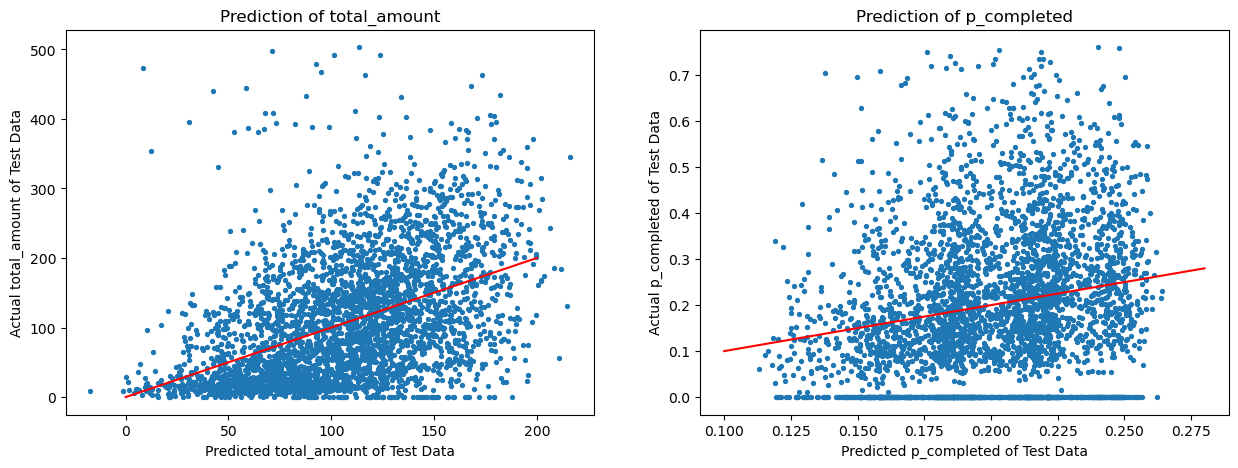

In [17]:
# plot the result of predicted data and actual data
x_1 = x = np.linspace(0, 200, 50)
x_2 = np.linspace(0.1, 0.28, 50)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(Y_pred[:, 0], Y_test.iloc[:, 0], s=8)
ax[0].set_xlabel('Predicted total_amount of Test Data')
ax[0].set_ylabel('Actual total_amount of Test Data')
ax[0].set_title('Prediction of total_amount')
ax[0].plot(x_1, x_1, color='red', linestyle='-') # line x=y

ax[1].scatter(Y_pred[:, 1], Y_test.iloc[:, 1], s=8)
ax[1].set_xlabel('Predicted p_completed of Test Data')
ax[1].set_ylabel('Actual p_completed of Test Data')
ax[1].set_title('Prediction of p_completed')
ax[1].plot(x_2, x_2, color='red', linestyle='-') # line x=y

plt.show()

The figure above shows that the majority of the points are distributed around the line x = y. But many of them are not close to the line. For the points whose actual value is 0, the predictions of linear regression are not good. So I will try xgboost and neural network to see if they can get better result, and if they perform better to predict the 0 observations.

---
# XGBoost

Linear regression and neural network can train a model from multiple input to multiple output. However XGBoost can only train the model with form multiple input to single output. Fortunately, sklearn provided a module `sklearn.multioutput.MultiOutputRegressor` . The strategy enables model to fit one regressor per target.

In [18]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

In [19]:
# create model
multi_xgb = MultiOutputRegressor(xgb.XGBRegressor(n_estimators=500, max_depth=5, min_child_weight=3,
                                                  learning_rate=0.025, gamma=0.2, subsample=0.9, 
                                                  colsample_bytree=0.7, reg_lambda=0.5, seed=1))
multi_xgb.fit(X_train_scaled, Y_train_scaled)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.2,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.025, max_bin=None,
                                            max_cat_threshold=None,
                       

After fitting the model, do the same steps as linear regression.

In [20]:
Y_pred_scaled = multi_xgb.predict(X_test_scaled)

In [21]:
# MAE of normalized data
mae_scaled = mean_absolute_error(Y_test_scaled, Y_pred_scaled)
print('MAE of scaled data: ', mae_scaled)

MAE of scaled data:  0.13892002013528165


In [22]:
# convert the predictions to origin range
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)

In [23]:
# MAE of two target features
mae = mean_absolute_error(Y_test, Y_pred)
print('MAE = ', mae)

MAE =  30.10751184487237


In [24]:
# MAE of each target features
mae = mean_absolute_error(Y_test.iloc[:, 0], Y_pred[:, 0])
print('total_amount MAE = ', mae)
mae = mean_absolute_error(Y_test.iloc[:, 1], Y_pred[:, 1])
print('p_completed MAE = ', mae)

total_amount MAE =  60.092653408915545
p_completed MAE =  0.12237028082919645


Linear regressor got 60.7934 as MAE for target total_amount and 0.1231 as MAE for target p_completed. The result of multioutput-xgboost is just a little bit better than linear regression.

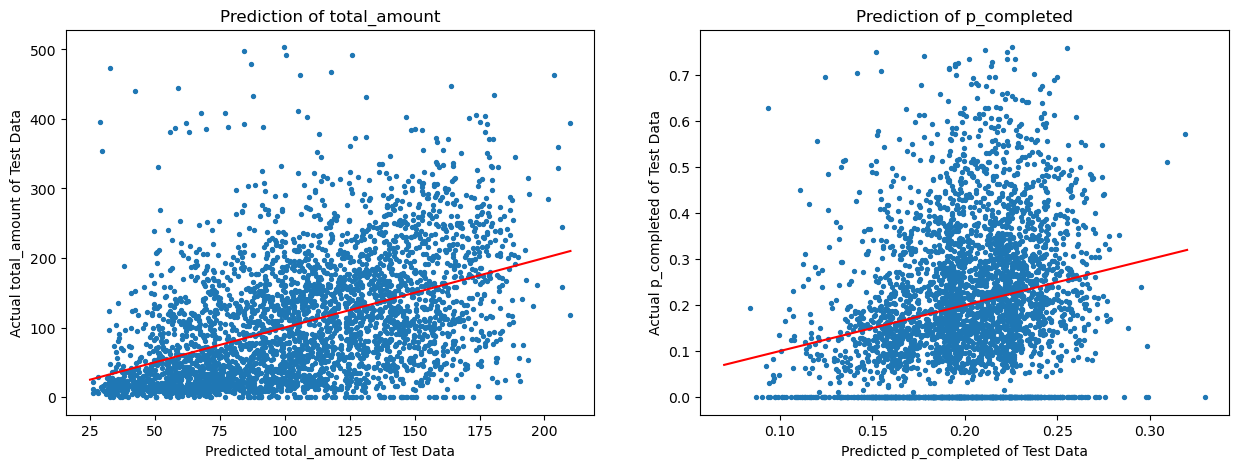

In [25]:
# plot the result of predicted data and actual data
x_1 = x = np.linspace(25, 210, 50)
x_2 = np.linspace(0.07, 0.32, 50)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(Y_pred[:, 0], Y_test.iloc[:, 0], s=8)
ax[0].set_xlabel('Predicted total_amount of Test Data')
ax[0].set_ylabel('Actual total_amount of Test Data')
ax[0].set_title('Prediction of total_amount')
ax[0].plot(x_1, x_1, color='red', linestyle='-') # line x=y

ax[1].scatter(Y_pred[:, 1], Y_test.iloc[:, 1], s=8)
ax[1].set_xlabel('Predicted p_completed of Test Data')
ax[1].set_ylabel('Actual p_completed of Test Data')
ax[1].set_title('Prediction of p_completed')
ax[1].plot(x_2, x_2, color='red', linestyle='-') # line x=y

plt.show()

I have tried some different parameters for XGBRegressor. And I got very close results to linear regression. The values of MAE are close. The scotter plots are similar. In fact, although `MultiOutputRegressor` can fit one regressor per target, the parameters of the regressors are same for different targets. So I'm going to split two target features in Y_train and Y_test and train the models separately for the two target features. Then to see if the results can be better.

To search specified parameter values for a model, I use `sklearn.model_selection.GridSearchCV` for parameter tuning. It's a powerful function provided in `sklearn`.It's efficient and allows more than one processes running in parallel for training jobs. But this can take long time if there are many parameters. For example, in this problem I chose 9 parameters in xgboost estimator. Each parameter has 3 values to try. There will be $3^9$ models to train if I don't divide this work into two parts. Thus for each XGBRegressor, I use `GridSearchCV` two times to get the parameters that make the model perform the best.

In [26]:
xgb_t = xgb.XGBRegressor(n_estimators=700, max_depth=6, min_child_weight=3, learning_rate=0.02, gamma=0.2, 
                         subsample=0.9, colsample_bytree=0.7, reg_alpha=0.5, reg_lambda=0.5, seed=1)

parameters = {
    'n_estimators': [700, 800, 900],
    'max_depth': [6, 7, 8],
    'min_child_weight': [3, 5, 7],
    'learning_rate': [0.01, 0.02, 0.05],
    'gamma': [0.1, 0.2, 0.5],
#     'subsample': [1, 0.9, 0.8],
#     'colsample_bytree': [0.6, 0.7, 0.8],
#     'reg_alpha': [0.1, 0.5, 1],
#     'reg_lambda': [0.4, 0.6, 0.8]
}

In [27]:
%%time
gsearch_0 = GridSearchCV(xgb_t, param_grid=parameters, scoring='neg_mean_squared_error', n_jobs=-1)
gsearch_0.fit(X_train_scaled, Y_train_scaled[:, 0])

CPU times: user 18.6 s, sys: 4.5 s, total: 23 s
Wall time: 5min 55s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.7,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.2, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.02, max_bin=...
                                    max_depth=6, max_leaves=None,
                                    min_child_weight=3, missing=nan,
                                    monotone_constraints=None, n_estimators=700,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, r

In [29]:
print("Best score: %0.3f" % gsearch_0.best_score_)
print("Best parameters set:")
best_parameters = gsearch_0.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: -0.024
Best parameters set:
	gamma: 0.1
	learning_rate: 0.02
	max_depth: 6
	min_child_weight: 5
	n_estimators: 700


Now I got the first five parameters, then I will search the last four parameters using the 5 parameters.

In [30]:
xgb_t = xgb.XGBRegressor(n_estimators=700, max_depth=6, min_child_weight=5, learning_rate=0.02, gamma=0.1, 
                        subsample=0.9, colsample_bytree=0.7, reg_alpha=0.5, reg_lambda=0.5, seed=1)

parameters = {
#     'n_estimators': [700, 800, 900],
#     'max_depth': [6, 7, 8],
#     'min_child_weight': [3, 5, 7],
#     'learning_rate': [0.01, 0.02, 0.05],
#     'gamma': [0.1, 0.2, 0.5],
    'subsample': [1, 0.9, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [0.1, 0.5, 1],
    'reg_lambda': [0.4, 0.6, 0.8]
}

In [31]:
%%time
gsearch_0 = GridSearchCV(xgb_t, param_grid=parameters, scoring='neg_mean_squared_error', n_jobs=-1)
gsearch_0.fit(X_train_scaled, Y_train_scaled[:, 0])

CPU times: user 15.5 s, sys: 3.71 s, total: 19.2 s
Wall time: 1min 38s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.7,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.1, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.02, max_bin=...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=6, max_leaves=None,
                                    min_child_weight=5, missing=nan,
                                    monotone_constraints=None, n_estimators=700,
                                    n_jobs=No

In [33]:
print("Best score: %0.3f" % gsearch_0.best_score_)
print("Best parameters set:")
best_parameters = gsearch_0.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: -0.024
Best parameters set:
	colsample_bytree: 0.6
	reg_alpha: 1
	reg_lambda: 0.8
	subsample: 0.8


`gsearch_0.best_estimator_` records the best estimator which gave highest score. Then I will use this best estimator to predict total_amount.

In [35]:
Y_pred_scaled_0 = gsearch_0.best_estimator_.predict(X_test_scaled)

In [36]:
# MAE of normalized data
mae_scaled = mean_absolute_error(Y_test_scaled[:, 0], Y_pred_scaled_0)
print('MAE of scaled data: ', mae_scaled)

MAE of scaled data:  0.11834492497576614


Now do the same process to train a XGBRegressor for the second target `p_completed`.

In [37]:
xgb_p = xgb.XGBRegressor(n_estimators=700, max_depth=5, min_child_weight=3, learning_rate=0.02, gamma=0.2, 
                         subsample=0.9, colsample_bytree=0.7, reg_alpha=0.5, reg_lambda=0.5, seed=1)

parameters = {
    'n_estimators': [600, 700, 800],
    'max_depth': [5, 6, 7],
    'min_child_weight': [3, 5, 7],
    'learning_rate': [0.01, 0.02, 0.05],
    'gamma': [0.1, 0.2, 0.5],
#     'subsample': [1, 0.9, 0.8],
#     'colsample_bytree': [0.6, 0.7, 0.8],
#     'reg_alpha': [0.1, 0.5, 1],
#     'reg_lambda': [0.4, 0.6, 0.8]
}

In [38]:
%%time
gsearch_1 = GridSearchCV(xgb_p, param_grid=parameters, scoring='neg_mean_squared_error', n_jobs=-1)
gsearch_1.fit(X_train_scaled, Y_train_scaled[:, 1])

CPU times: user 16.9 s, sys: 3.83 s, total: 20.7 s
Wall time: 4min 26s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.7,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.2, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.02, max_bin=...
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=3, missing=nan,
                                    monotone_constraints=None, n_estimators=700,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, r

In [40]:
print("Best score: %0.3f" % gsearch_1.best_score_)
print("Best parameters set:")
best_parameters = gsearch_1.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: -0.045
Best parameters set:
	gamma: 0.5
	learning_rate: 0.05
	max_depth: 5
	min_child_weight: 3
	n_estimators: 800


In [41]:
xgb_p = xgb.XGBRegressor(n_estimators=800, max_depth=5, min_child_weight=3, learning_rate=0.05, gamma=0.5, 
                         subsample=0.9, colsample_bytree=0.7, reg_alpha=0.5, reg_lambda=0.5, seed=1)

parameters = {
#     'n_estimators': [600, 700, 800],
#     'max_depth': [5, 6, 7],
#     'min_child_weight': [3, 5, 7],
#     'learning_rate': [0.01, 0.02, 0.05],
#     'gamma': [0.1, 0.2, 0.5],
    'subsample': [1, 0.9, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [0.1, 0.5, 1],
    'reg_lambda': [0.4, 0.6, 0.8]
}

In [42]:
%%time
gsearch_1 = GridSearchCV(xgb_p, param_grid=parameters, scoring='neg_mean_squared_error', n_jobs=-1)
gsearch_1.fit(X_train_scaled, Y_train_scaled[:, 1])

CPU times: user 14.6 s, sys: 3.51 s, total: 18.1 s
Wall time: 1min 30s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.7,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.5, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.05, max_bin=...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=3, missing=nan,
                                    monotone_constraints=None, n_estimators=800,
                                    n_jobs=No

In [43]:
print("Best score: %0.3f" % gsearch_1.best_score_)
print("Best parameters set:")
best_parameters = gsearch_1.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: -0.044
Best parameters set:
	colsample_bytree: 0.6
	reg_alpha: 0.5
	reg_lambda: 0.4
	subsample: 0.9


In [44]:
Y_pred_scaled_1 = gsearch_1.best_estimator_.predict(X_test_scaled)

In [45]:
# MAE of normalized data
mae_scaled = mean_absolute_error(Y_test_scaled[:, 1], Y_pred_scaled_1)
print('MAE of scaled data: ', mae_scaled)

MAE of scaled data:  0.15935196105676613


Now I got the predictions for both target features total_amount and p_completed. But the result is scaled. So unscale the predicted data and compare metrics.

In [46]:
Y_pred_scaled = np.concatenate(
    (Y_pred_scaled_0.reshape(len(Y_pred_scaled_0), 1), 
     Y_pred_scaled_1.reshape(len(Y_pred_scaled_1), 1)), axis=1)

In [47]:
# convert the predictions to origin range
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)

In [48]:
# MAE of two target features
mae = mean_absolute_error(Y_test, Y_pred)
print('MAE = ', mae)

MAE =  30.016735512789865


In [49]:
# MAE of each target features
mae = mean_absolute_error(Y_test.iloc[:, 0], Y_pred[:, 0])
print('total_amount MAE = ', mae)
mae = mean_absolute_error(Y_test.iloc[:, 1], Y_pred[:, 1])
print('p_completed MAE = ', mae)

total_amount MAE =  59.91093479945816
p_completed MAE =  0.12253622612142015


Comparing with the results of multioutput-xgboost, by training estimator separately, MAE of total_amount and p_completed are both reduced a bit but not too much.

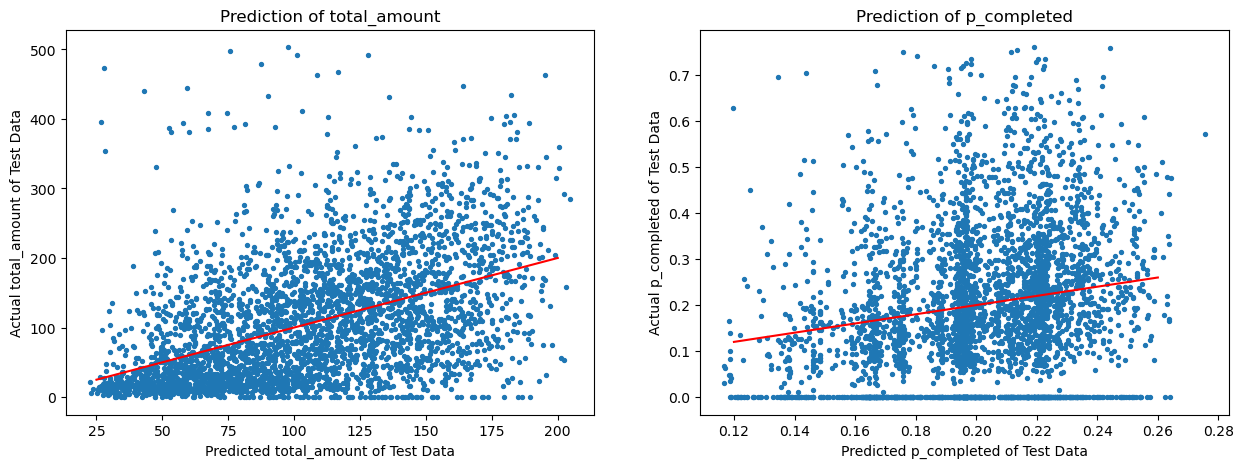

In [50]:
# plot the result of predicted data and actual data
x_1 = x = np.linspace(25, 200, 50)
x_2 = np.linspace(0.12, 0.26, 50)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(Y_pred[:, 0], Y_test.iloc[:, 0], s=8)
ax[0].set_xlabel('Predicted total_amount of Test Data')
ax[0].set_ylabel('Actual total_amount of Test Data')
ax[0].set_title('Prediction of total_amount')
ax[0].plot(x_1, x_1, color='red', linestyle='-') # line x=y

ax[1].scatter(Y_pred[:, 1], Y_test.iloc[:, 1], s=8)
ax[1].set_xlabel('Predicted p_completed of Test Data')
ax[1].set_ylabel('Actual p_completed of Test Data')
ax[1].set_title('Prediction of p_completed')
ax[1].plot(x_2, x_2, color='red', linestyle='-') # line x=y

plt.show()

For the observations whose target variable values are 0, this XGBoost estimator hasn't solved the problem of inaccurate prediction of 0. Then see if this problem can be solved by neural network.

---
# TensorFlow

In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

A multilayer perceptron (MLP) is a fully connected class of artificial neural network (ANN). I create a MLP with 3 non-linear hidden layers using tensorflow and keras.

In [52]:
# create class for Multilayer Perceptron (MLP)
class MLP(keras.Model):
    
    def __init__(self):
        super().__init__()
        self.dense1 = layers.Dense(units=10, activation=tf.nn.sigmoid)
        self.dense2 = layers.Dense(units=10, activation=tf.nn.sigmoid)
        self.dense3 = layers.Dense(units=2, activation=tf.nn.sigmoid)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        output = self.dense3(x)
        return output

In [54]:
# creat model
model = MLP()

In [55]:
# set optimizer, loss function and metrics
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.mean_squared_error,
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [56]:
model.fit(X_train_scaled, Y_train_scaled, validation_split=0.1, batch_size=64, verbose=1, epochs=100)

Epoch 1/100
149/149 [==============================] - 0s 1ms/step - loss: 0.0490 - mean_absolute_error: 0.1812 - val_loss: 0.0367 - val_mean_absolute_error: 0.1526
Epoch 2/100
149/149 [==============================] - 0s 689us/step - loss: 0.0385 - mean_absolute_error: 0.1556 - val_loss: 0.0366 - val_mean_absolute_error: 0.1501
Epoch 3/100
149/149 [==============================] - 0s 708us/step - loss: 0.0384 - mean_absolute_error: 0.1545 - val_loss: 0.0365 - val_mean_absolute_error: 0.1501
Epoch 4/100
149/149 [==============================] - 0s 702us/step - loss: 0.0383 - mean_absolute_error: 0.1543 - val_loss: 0.0365 - val_mean_absolute_error: 0.1499
Epoch 5/100
149/149 [==============================] - 0s 689us/step - loss: 0.0382 - mean_absolute_error: 0.1541 - val_loss: 0.0364 - val_mean_absolute_error: 0.1495
Epoch 6/100
149/149 [==============================] - 0s 680us/step - loss: 0.0381 - mean_absolute_error: 0.1537 - val_loss: 0.0362 - val_mean_absolute_error: 0.1494


Epoch 50/100
149/149 [==============================] - 0s 688us/step - loss: 0.0345 - mean_absolute_error: 0.1419 - val_loss: 0.0325 - val_mean_absolute_error: 0.1382
Epoch 51/100
149/149 [==============================] - 0s 658us/step - loss: 0.0345 - mean_absolute_error: 0.1421 - val_loss: 0.0326 - val_mean_absolute_error: 0.1379
Epoch 52/100
149/149 [==============================] - 0s 656us/step - loss: 0.0345 - mean_absolute_error: 0.1419 - val_loss: 0.0325 - val_mean_absolute_error: 0.1382
Epoch 53/100
149/149 [==============================] - 0s 664us/step - loss: 0.0345 - mean_absolute_error: 0.1419 - val_loss: 0.0326 - val_mean_absolute_error: 0.1382
Epoch 54/100
149/149 [==============================] - 0s 659us/step - loss: 0.0345 - mean_absolute_error: 0.1419 - val_loss: 0.0326 - val_mean_absolute_error: 0.1382
Epoch 55/100
149/149 [==============================] - 0s 647us/step - loss: 0.0345 - mean_absolute_error: 0.1419 - val_loss: 0.0325 - val_mean_absolute_error:

Epoch 99/100
149/149 [==============================] - 0s 667us/step - loss: 0.0344 - mean_absolute_error: 0.1416 - val_loss: 0.0323 - val_mean_absolute_error: 0.1381
Epoch 100/100
149/149 [==============================] - 0s 644us/step - loss: 0.0344 - mean_absolute_error: 0.1416 - val_loss: 0.0323 - val_mean_absolute_error: 0.1379


After fitting estimator, make predictions.

In [57]:
Y_pred_scaled = model.predict(X_test_scaled)

111/111 [==============================] - 0s 436us/step


In [58]:
# MAE of normalized data
mae_scaled = mean_absolute_error(Y_test_scaled, Y_pred_scaled)
print('MAE of scaled data: ', mae_scaled)

MAE of scaled data:  0.13966531693101233


In [59]:
# convert the predictions to origin range
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)

In [60]:
# MAE of two target features
mae = mean_absolute_error(Y_test, Y_pred)
print('MAE = ', mae)

MAE =  30.1935487207495


In [61]:
# MAE of each target features
mae = mean_absolute_error(Y_test.iloc[:, 0], Y_pred[:, 0])
print('MAE = ', mae)
mae = mean_absolute_error(Y_test.iloc[:, 1], Y_pred[:, 1])
print('MAE = ', mae)

MAE =  60.26384097453959
MAE =  0.12325646695925445


Linear regressor got 60.7934 as MAE for target total_amount and 0.1231 as MAE for target p_completed. The prediction of total_amount using MLP is a little bit better than linear regression. However the result of p_completed is not as well as linear regression.

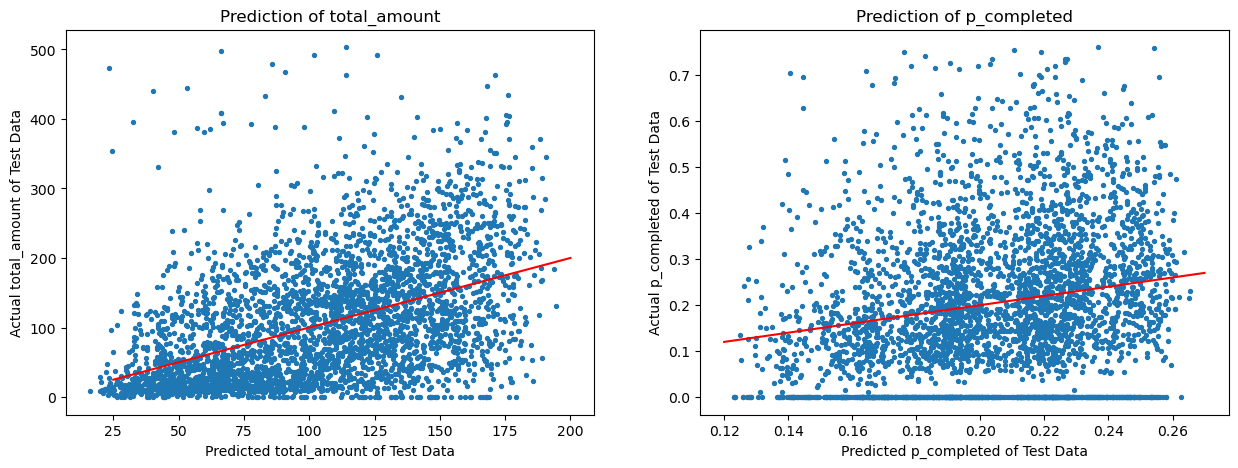

In [64]:
# plot the result of predicted data and actual data
x_1 = x = np.linspace(25, 200, 50)
x_2 = np.linspace(0.12, 0.27, 50)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(Y_pred[:, 0], Y_test.iloc[:, 0], s=8)
ax[0].set_xlabel('Predicted total_amount of Test Data')
ax[0].set_ylabel('Actual total_amount of Test Data')
ax[0].set_title('Prediction of total_amount')
ax[0].plot(x_1, x_1, color='red', linestyle='-') # line x=y

ax[1].scatter(Y_pred[:, 1], Y_test.iloc[:, 1], s=8)
ax[1].set_xlabel('Predicted p_completed of Test Data')
ax[1].set_ylabel('Actual p_completed of Test Data')
ax[1].set_title('Prediction of p_completed')
ax[1].plot(x_2, x_2, color='red', linestyle='-') # line x=y

plt.show()

The plot shows that the neural network also did not solve the problem of predicting 0.

---
# Conclusion

The three algorithms perform not too bad. But the errors obtained are not small. And the models still need to be optimized. XGBoost which was trained separately for each target feature performs the best among the three models with MAE values equal to 59.9109 and 0.1225 for total_amount and p_completed respectively.

However, it is worth noting that the performances of these models are almost the same. They all have limit to predict 0. This problem may be related to the data. In fact the dimention of input is not so large. It exists some outliers in the dataset even after deleting some of them. And the rules that I created to calculate p_completed may not be great.

Considering the actual situation of this problem, for the observations with target features equal to 0, the models all have a prediction greater than 0. 

For total_amount this means that, for example, the prediction of the amount a customer spent at Starbucks is $100, while this customer never bought any product. There might be some reasons, like they can afford but they didn't recevie offers. 

For p_completed this means that the prediction of the probability a customer complete an offer is 15\%, but this customer didn't complete any offer. The possible reasons for this situation can be more, for example, they bought some products but the amount was less than the difficulty of the offer, or the transactions happened after the validity period, or the offers that this customer recevied are advertisements.

To check these samples again, we may get more informations about inaccurate predictions. Then we can find out how to improve the models.
